In [1]:
import nltk
nltk.download('punkt')
from collections import Counter
import operator
import plotly.express as px
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS
import nltk
import re
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from tensorflow.keras.preprocessing.text import one_hot, Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, TimeDistributed, RepeatVector, Embedding, Input, LSTM, Conv1D, MaxPool1D, Bidirectional
from tensorflow.keras.models import Model
import dask.dataframe as dd


[nltk_data] Downloading package punkt to /home/gagandeep/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
### We will start by loading in the data.
df_english = dd.read_csv('small_vocab_en.csv', header=None, names=['english'], sep='\t')
df_french = dd.read_csv('small_vocab_fr.csv', header=None, names=['french'], sep='\t')


In [3]:
df_english.head()

english
0  new jersey is sometimes quiet during autumn , ...
1  the united states is usually chilly during jul...
2  california is usually quiet during march , and...
3  the united states is sometimes mild during jun...
4  your least liked fruit is the grape , but my l...

In [4]:
df_french.head()

french
0  new jersey est parfois calme pendant l' automn...
1  les états-unis est généralement froid en juill...
2  california est généralement calme en mars , et...
3  les états-unis est parfois légère en juin , et...
4  votre moins aimé fruit est le raisin , mais mo...

In [5]:
print("The shape of english dataset is {},{}". format(df_english.shape[0].compute(),len(df_english.columns)))
print("The shape of french dataset is {},{}". format(df_french.shape[0].compute(),len(df_french.columns)))

The shape of english dataset is 137860,1
The shape of french dataset is 137860,1


### The approach used to create language transalator is very simple. We will use encoder decoder architecutre with LSTM Seq2Seq model. Seq2Seq is called a sequence to sequence model where the input and output are vectors. The vectors can be of fixed length or variable length. In case of variable length, we pad our sequences. In our example, english text is the input and french text is the output. Before feeding the data to the model, we need to clean and preprocess the data. We start by combining the data followed by cleaning the text and tokenizing the data.

In [6]:
df = dd.concat([df_english,df_french], axis=1)
df.head()

/home/gagandeep/.local/lib/python3.6/site-packages/dask/dataframe/multi.py:1095: UserWarning:

Concatenating dataframes with unknown divisions.
We're assuming that the indexes of each dataframes are 
 aligned. This assumption is not generally safe.



english  \
0  new jersey is sometimes quiet during autumn , ...   
1  the united states is usually chilly during jul...   
2  california is usually quiet during march , and...   
3  the united states is sometimes mild during jun...   
4  your least liked fruit is the grape , but my l...   

                                              french  
0  new jersey est parfois calme pendant l' automn...  
1  les états-unis est généralement froid en juill...  
2  california est généralement calme en mars , et...  
3  les états-unis est parfois légère en juin , et...  
4  votre moins aimé fruit est le raisin , mais mo...

In [7]:
print("The shape of combined dataset is {},{}". format(df.shape[0].compute(),len(df.columns)))

The shape of combined dataset is 137860,2


In [8]:
# Remove Punctuatiom
def remove_punc(x):
    pat = '[!#?,.:";]'
    return re.sub(pat, '', x)

In [9]:
df['english'] = df['english'].apply(remove_punc, meta=('english', 'object'))
df['french'] = df['french'].apply(remove_punc, meta=('french', 'object'))

In [10]:
# Find unique words
english_words = []
french_words = []
def get_unique_words(x, word_list):
    for word in x.split():
        if word not in word_list:
            word_list.append(word)

In [11]:
df['english'].apply(lambda x: get_unique_words(x,word_list=english_words), meta=('english', 'object')).compute()
len(english_words)

199

In [12]:
df['french'].apply(lambda x: get_unique_words(x,word_list=french_words), meta=('french', 'object')).compute()
len(french_words)

350

In [13]:
# number of unique words in english
total_english_words  = len(english_words)
# number of unique words in french
total_french_words = len(french_words)

### Visualization
### English Data

In [14]:
# Obtain list of all words in the dataset
words = []
for i in df['english']:
  for word in i.split():
    words.append(word)

In [15]:
# Obtain the total count of words
english_words_counts = Counter(words)

In [16]:
# sort the dictionary by values
english_words_counts = sorted(english_words_counts.items(), key = operator.itemgetter(1), reverse = True)

In [17]:
# append the values to a list for visualization purposes
english_words = []
english_counts = []
for i in range(len(english_words_counts)):
  english_words.append(english_words_counts[i][0])
  english_counts.append(english_words_counts[i][1])

In [18]:
# Plot barplot using plotly 
fig = px.bar(x = english_words, y = english_counts)
fig.show()

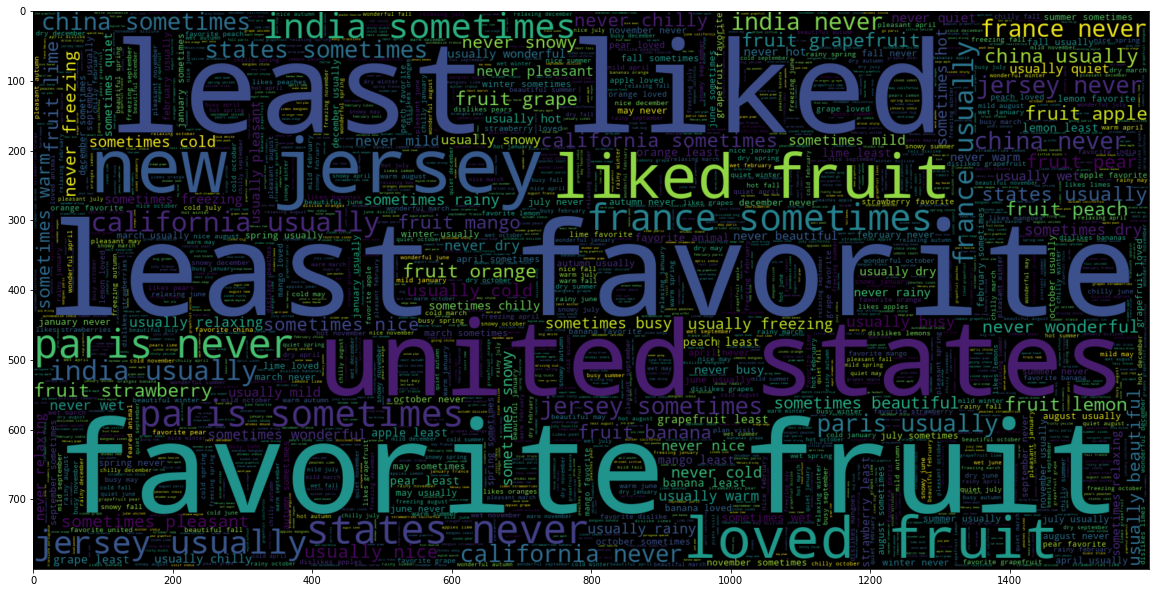

In [19]:
# plot the word cloud for text that is Real
plt.figure(figsize = (20,20)) 
wc = WordCloud(max_words = 2000, width = 1600, height = 800 ).generate(" ".join(df.english))
plt.imshow(wc, interpolation = 'bilinear')

In [20]:
# Maximum length (number of words) per document. We will need it later for embeddings
maxlen_english = -1
for doc in df.english:
    tokens = nltk.word_tokenize(doc)
    if(maxlen_english < len(tokens)):
        maxlen_english = len(tokens)
print("The maximum number of words in any document = ", maxlen_english)

The maximum number of words in any document =  15


In [21]:
# obtain the count of french words
words = []
for i in df['french']:
  for word in i.split():
    words.append(word)

In [22]:
french_words_counts = Counter(words)
# sort the dictionary by values
french_words_counts = sorted(french_words_counts.items(), key = operator.itemgetter(1), reverse = True)

In [23]:
# append the values to a list for visuaization purpose
french_words = []
french_counts = []
for i in range(len(french_words_counts)):
  french_words.append(french_words_counts[i][0])
  french_counts.append(french_words_counts[i][1])

In [24]:
fig = px.bar(x = french_words, y = french_counts)
fig.show()

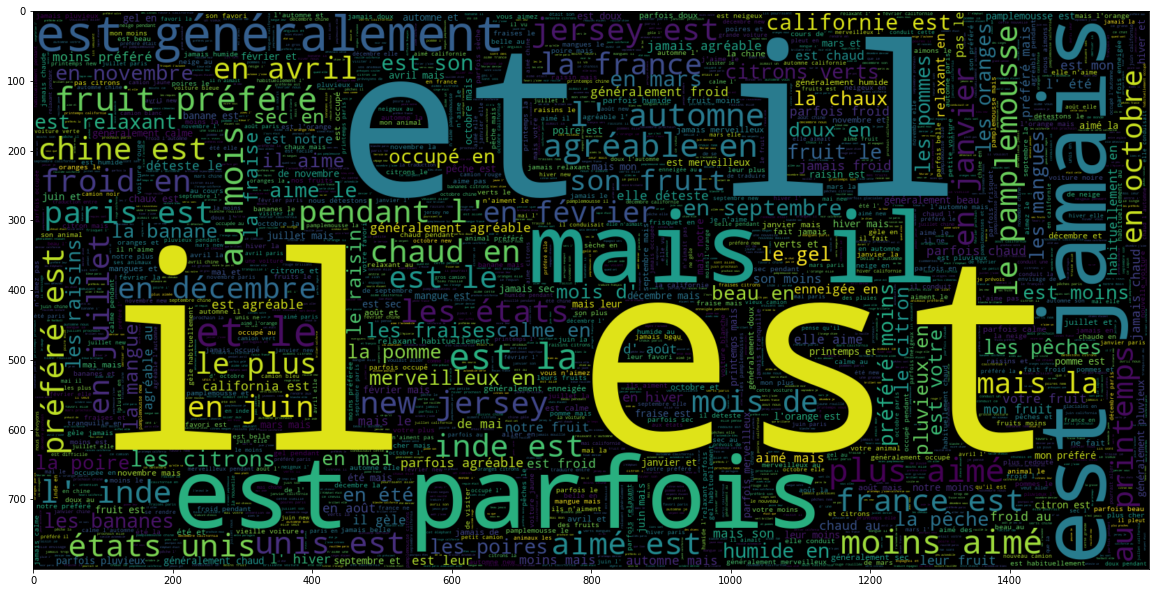

In [25]:
# plot the word cloud for French
plt.figure(figsize = (20,20)) 
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800).generate(" ".join(df.french))
plt.imshow(wc, interpolation = 'bilinear')

In [26]:

# Maximum length (number of words) per document. We will need it later for embeddings
maxlen_french = -1
for doc in df.french:
    tokens = nltk.word_tokenize(doc)
    if(maxlen_french < len(tokens)):
        maxlen_french = len(tokens)
print("The maximum number of words in any document = ", maxlen_french)

The maximum number of words in any document =  23


### Tokenizing Data

In [27]:
def toeknize_and_pad(x, maxlen):
    tokenizer = Tokenizer(char_level=False)
    tokenizer.fit_on_texts(x)
    sequences = tokenizer.texts_to_sequences(x)
    padded = pad_sequences(sequences=sequences, maxlen=maxlen, padding='post')
    return tokenizer, sequences, padded

In [28]:
x_tokenizer, x_sequences, x_padded = toeknize_and_pad(df['english'], maxlen_french)

In [29]:
x_sequences[:10]

[[17, 23, 1, 8, 67, 4, 39, 7, 3, 1, 55, 2, 44],
 [5, 20, 21, 1, 9, 62, 4, 43, 7, 3, 1, 9, 51, 2, 45],
 [22, 1, 9, 67, 4, 38, 7, 3, 1, 9, 68, 2, 34],
 [5, 20, 21, 1, 8, 64, 4, 34, 7, 3, 1, 57, 2, 42],
 [29, 12, 16, 13, 1, 5, 82, 6, 30, 12, 16, 1, 5, 83],
 [31, 11, 13, 1, 5, 84, 6, 30, 11, 1, 5, 82],
 [18, 1, 66, 4, 47, 6, 3, 1, 9, 62, 2, 43],
 [17, 23, 1, 60, 4, 35, 7, 3, 1, 10, 68, 2, 38],
 [49, 12, 16, 13, 1, 5, 85, 6, 30, 12, 16, 1, 5, 82],
 [5, 20, 21, 1, 8, 60, 4, 36, 7, 3, 1, 8, 56, 2, 45]]

In [30]:
x_padded[:10]

array([[17, 23,  1,  8, 67,  4, 39,  7,  3,  1, 55,  2, 44,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0],
       [ 5, 20, 21,  1,  9, 62,  4, 43,  7,  3,  1,  9, 51,  2, 45,  0,
         0,  0,  0,  0,  0,  0,  0],
       [22,  1,  9, 67,  4, 38,  7,  3,  1,  9, 68,  2, 34,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0],
       [ 5, 20, 21,  1,  8, 64,  4, 34,  7,  3,  1, 57,  2, 42,  0,  0,
         0,  0,  0,  0,  0,  0,  0],
       [29, 12, 16, 13,  1,  5, 82,  6, 30, 12, 16,  1,  5, 83,  0,  0,
         0,  0,  0,  0,  0,  0,  0],
       [31, 11, 13,  1,  5, 84,  6, 30, 11,  1,  5, 82,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0],
       [18,  1, 66,  4, 47,  6,  3,  1,  9, 62,  2, 43,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0],
       [17, 23,  1, 60,  4, 35,  7,  3,  1, 10, 68,  2, 38,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0],
       [49, 12, 16, 13,  1,  5, 85,  6, 30, 12, 16,  1,  5, 82,  0,  0,
         0,  0,  0,  0,  0,  0,  0],
       [ 5, 20, 21,

In [31]:
y_tokenizer, y_sequences, y_padded = toeknize_and_pad(df['french'], maxlen_french)

In [32]:
y_sequences[:10]

[[35, 34, 1, 8, 67, 37, 11, 24, 6, 3, 1, 112, 2, 50],
 [4, 32, 31, 1, 12, 19, 2, 49, 6, 3, 95, 69, 2, 51],
 [101, 1, 12, 67, 2, 45, 6, 3, 1, 12, 21, 2, 41],
 [4, 32, 31, 1, 8, 269, 2, 41, 6, 3, 103, 19, 2, 48],
 [40, 13, 14, 16, 1, 10, 82, 5, 39, 13, 14, 1, 7, 83],
 [20, 16, 17, 1, 84, 5, 39, 17, 1, 10, 82],
 [29, 1, 58, 2, 52, 5, 3, 1, 12, 19, 2, 49],
 [35, 34, 1, 65, 15, 42, 6, 3, 1, 9, 125, 2, 45],
 [61, 16, 1, 13, 14, 10, 85, 5, 39, 13, 14, 1, 10, 82],
 [4, 32, 31, 1, 8, 65, 2, 43, 6, 3, 1, 8, 21, 2, 51]]

In [33]:
y_padded[:10]

array([[ 35,  34,   1,   8,  67,  37,  11,  24,   6,   3,   1, 112,   2,
         50,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  4,  32,  31,   1,  12,  19,   2,  49,   6,   3,  95,  69,   2,
         51,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [101,   1,  12,  67,   2,  45,   6,   3,   1,  12,  21,   2,  41,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  4,  32,  31,   1,   8, 269,   2,  41,   6,   3, 103,  19,   2,
         48,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [ 40,  13,  14,  16,   1,  10,  82,   5,  39,  13,  14,   1,   7,
         83,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [ 20,  16,  17,   1,  84,   5,  39,  17,   1,  10,  82,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [ 29,   1,  58,   2,  52,   5,   3,   1,  12,  19,   2,  49,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [ 35,  34,   1,  65,  15,  42,   6,   3,   1,   9, 125,   2,  45,
   

In [34]:
# Total vocab size, since we added padding we add 1 to the total word count
english_vocab_size = total_english_words + 1
print("Complete English Vocab Size:", english_vocab_size)

Complete English Vocab Size: 200


In [35]:
# Total vocab size, since we added padding we add 1 to the total word count
french_vocab_size = total_french_words + 1
print("Complete French Vocab Size:", french_vocab_size)

Complete French Vocab Size: 351


In [36]:
df['english'].head(2)

0    new jersey is sometimes quiet during autumn  a...
1    the united states is usually chilly during jul...
Name: english, dtype: object

In [37]:
x_padded[:2]

array([[17, 23,  1,  8, 67,  4, 39,  7,  3,  1, 55,  2, 44,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0],
       [ 5, 20, 21,  1,  9, 62,  4, 43,  7,  3,  1,  9, 51,  2, 45,  0,
         0,  0,  0,  0,  0,  0,  0]], dtype=int32)

In [38]:
df['french'].head(2)

0    new jersey est parfois calme pendant l' automn...
1    les états-unis est généralement froid en juill...
Name: french, dtype: object

In [39]:
y_padded[:2]

array([[ 35,  34,   1,   8,  67,  37,  11,  24,   6,   3,   1, 112,   2,
         50,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  4,  32,  31,   1,  12,  19,   2,  49,   6,   3,  95,  69,   2,
         51,   0,   0,   0,   0,   0,   0,   0,   0,   0]], dtype=int32)

In [40]:
import pickle
op_name_list = [['x_tokenizer', 'x_sequences', 'x_padded'], ['y_tokenizer', 'y_sequences', 'y_padded']]
op_obj_list = [[x_tokenizer, x_sequences, x_padded], [y_tokenizer, y_sequences, y_padded]]

for i in range(len(op_name_list)):
    for j in range(len(op_name_list[i])):
        with open(op_name_list[i][j] + '.pkl', 'wb') as pickle_out:
            pickle.dump(op_obj_list[i][j], pickle_out)
            pickle_out.close()

In [41]:
# Train test split
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x_padded, y_padded, test_size = 0.1)

### Build the model

In [42]:
model = Sequential()
# Add embedding layer
model.add(Embedding(english_vocab_size,256, input_length=maxlen_french, mask_zero=True))
# Add Bidirectional LSTM - encoder
model.add(Bidirectional(LSTM(256)))
# decoder
# Add repeatvectort - epeats the input for the desired number of times to change
# 2D-array to 3D array. For example: (1,256) to (1,23,256)
model.add(RepeatVector(maxlen_french))
model.add(LSTM(256, return_sequences= True ))
model.add(TimeDistributed(Dense(french_vocab_size, activation ='softmax')))
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 23, 256)           51200     
_________________________________________________________________
bidirectional (Bidirectional (None, 512)               1050624   
_________________________________________________________________
repeat_vector (RepeatVector) (None, 23, 512)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 23, 256)           787456    
_________________________________________________________________
time_distributed (TimeDistri (None, 23, 351)           90207     
Total params: 1,979,487
Trainable params: 1,979,487
Non-trainable params: 0
_________________________________________________________________


In [109]:
# change the shape of target from 2D to 3D
y_train = np.expand_dims(y_train, axis = 2)
y_train.shape

(124074, 23, 1)

In [ ]:
# train the model
model.fit(x_train, y_train, batch_size=128, validation_split= 0.1, epochs=10)